# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [9]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import convolve2d
# Useful functions 
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [10]:
def computeR(image,scale,kappa=0.04):
    """ Array[n, m]*float*float->Array[n, m]
    """
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    Ix = convolve2d(image, sobel_x, mode='same')
    Iy = convolve2d(image, sobel_y, mode='same')

    # 2. Compute the products Ix^2, Iy^2, and Ix*Iy.
    Ix2 = Ix**2
    Iy2 = Iy**2
    IxIy = Ix*Iy
    
    # 3. Convolve these products with a Gaussian kernel.
    gauss_kernel = gaussianKernel(scale)
    
    Ix2 = convolve2d(Ix2, gauss_kernel, mode='same')
    Iy2 = convolve2d(Iy2, gauss_kernel, mode='same')
    IxIy = convolve2d(IxIy, gauss_kernel, mode='same')
    
    # 4. Compute the determinant and trace of the matrix M(x,y) for each pixel.
    det_M = Ix2*Iy2 - IxIy**2
    trace_M = Ix2 + Iy2
    
    # 5. Compute the Harris response using the formula provided.
    R = det_M - kappa * (trace_M**2)
    
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

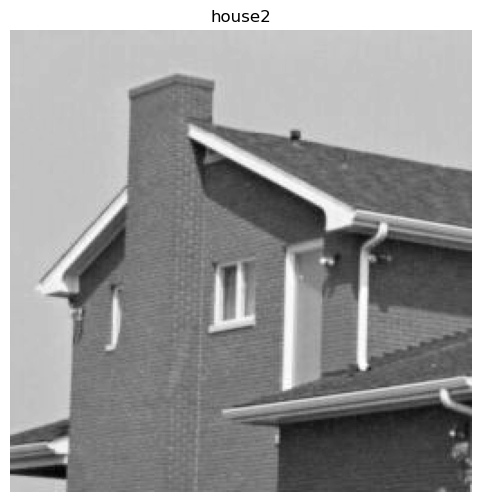

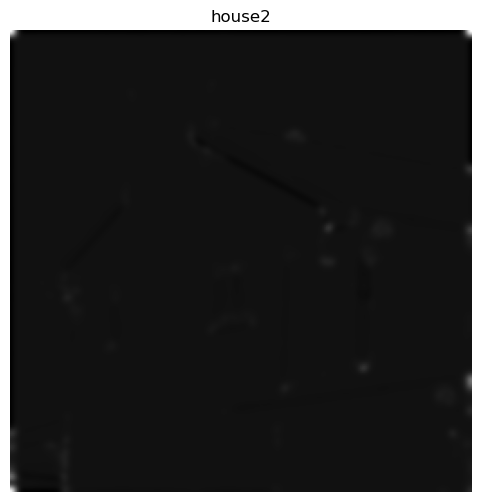

In [72]:
house2 = np.array(Image.open("img/house2.png").convert('L')) 
house2_corners = computeR(house2,2.3)
imshow(house2, title='house2')
imshow(house2_corners, title='house2')

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

The Harris response measures intensity changes in different directions:

Homogeneous Areas: Low response due to uniform intensities.

Edges: Intermediate response; intensity changes significantly in one direction.

Corners: High response; intensity changes in multiple directions.

Thus, it discriminates between uniform regions, edges, and corners based on intensity variation.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [73]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    Rb = np.where(R > thres, 1, 0)
    return Rb

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [95]:
# def rnms(R, Rbin):
#     """Perform non-maximum suppression on Harris response."""
#     # Create an output array initialized with zeros
#     Rlocmax = np.zeros_like(R)
    
#     # Define the neighborhood
#     rows, cols = R.shape
#     for i in range(1, rows-1):
#         for j in range(1, cols-1):
#             # Check if the pixel is a local maximum and is binarized as 1
#             neighborhood = R[i-1:i+2, j-1:j+2]
#             if (R[i, j] == np.max(neighborhood)) and (Rbin[i, j] == 1):
#                 Rlocmax[i, j] = 1
                
#     return Rlocmax

def rnms(R, Rbin):
    Rlocmax = np.zeros_like(R)
    
    # Define the 8 possible shifts (for 8 neighbors)
    shifts = [(-1, -1), (-1, 0), (-1, 1),
              (0, -1),           (0, 1),
              (1, -1), (1, 0), (1, 1)]
    
    # Start by assuming all points are local maxima
    is_maxima = np.ones(R.shape, dtype=bool)
    
    for shift in shifts:
        # Roll the response matrix
        rolled = np.roll(R, shift=shift, axis=(0,1))
        
        # Update the is_maxima mask
        is_maxima &= (R >= rolled)
    
    # Combine the local maxima mask with the binary mask
    Rlocmax[is_maxima & (Rbin == 1)] = 1
    
    return Rlocmax


3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [75]:
import numpy as np

def cornerDetector(image, scale, kappa, thresh):
    
    # Compute the Harris response
    R = computeR(image, scale, kappa)
    
    # Threshold the Harris response
    Rbin = thresholdR(R, thresh)
    
    # Apply non-maximum suppression
    corners = rnms(R, Rbin)
    
    return corners


4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

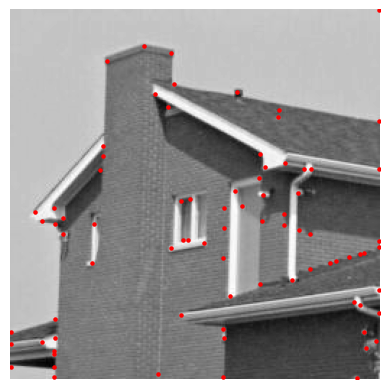

In [116]:

scale = 2.3 # Given a window size of W=15 pixels
kappa = 0.04
R = computeR(house2, scale, kappa)
thresh = 0.0003 * R.max() 

corners = cornerDetector(house2, scale, kappa, thresh)

# Get the x, y coordinates of the detected corners
y, x = np.nonzero(corners)

plt.imshow(house2, cmap='gray')
plt.scatter(x, y, c='red', s=5) 
plt.axis('off')
plt.show()


5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

After a lot of tests, the optimal value of sigma which i found is 2.3, and for threshold is 0.0003 * R.max()

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

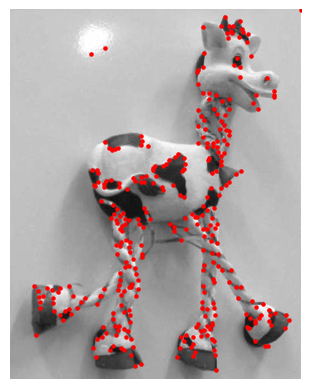

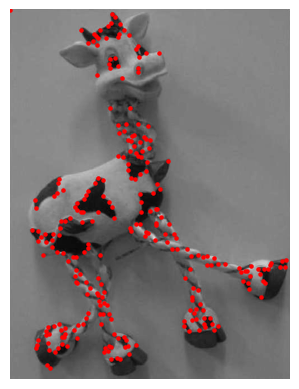

In [115]:
toyHorse1 = np.array(Image.open("img/toyHorse1.png")) 
 
    
corners = cornerDetector(toyHorse1, scale, kappa, thresh)

# Get the x, y coordinates of the detected corners
y, x = np.nonzero(corners)

plt.imshow(toyHorse1, cmap='gray')
plt.scatter(x, y, c='red', s=5)  
plt.axis('off')
plt.show()


toyHorse2 = np.array(Image.open("img/toyHorse2.png"))

corners = cornerDetector(toyHorse2, scale, kappa, thresh)

y, x = np.nonzero(corners)

plt.imshow(toyHorse2, cmap='gray')
plt.scatter(x, y, c='red', s=5)  
plt.axis('off')
plt.show()


2) What are the dynamic ranges of these two images ?

Your answer...

In [52]:
def dynamic_range(image_path):
    """Calculate and print the dynamic range of an image."""
    image = np.array(Image.open(image_path))

    min_val = image.min()
    max_val = image.max()

    return min_val, max_val

min1, max1 = dynamic_range("img/toyHorse1.png")
min2, max2 = dynamic_range("img/toyHorse2.png")

print(f"Dynamic range for img/toyHorse1.png: {min1} - {max1}")
print(f"Dynamic range for img/toyHorse2.png: {min2} - {max2}")


Dynamic range for img/toyHorse1.png: 1 - 255
Dynamic range for img/toyHorse2.png: 0 - 253


3) What are the transformations beetween the two images ?

the main transformations between "toyHorse1" and "toyHorse2" appear to be a slight upward translation and a minor counter-clockwise rotation of "toyHorse2" relative to "toyHorse1".

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Harris corner detection is rotation invariant, but not invariant to affine transformations of brightness.
Using a fixed threshold, the number and locations of detected corners can indeed change with brightness or contrast modifications, making the detection sensitive to such transformations